# Convolutional Neural Network(CNN)

### **Requisitos**


Antes de iniciarmos com nossa análise, será necessário efetuar o download:

- **Python 3.7**
- **Anaconda**
- **Jupyter Notebook**
- **Efetuar download do arquivo no Kaggle: <https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data>**

**Como instalar em seu computador?**

**Necessário abrir anaconda prompt (anaconda3) e executar esses comandos:**

- pip install tflearn
- pip install tensorflow==1.15
- pip install tqdm

As imagens são de cachorro (s) ou gato (s).

Iremos **analisar e classificas as imagens** que já foram rotuladas, posteriormente iremos alimentar através de uma rede neural convolucional para classificação.

Depois de baixar e extrair os dados, estaremos prontos para começar.

**Primeiro, precisamos que todas as imagens tenham o mesmo tamanho e, em seguida, provavelmente também queremos apenas colocá-las em escala de cinza. Além disso, os rótulos de "gato" e "cachorro" não são úteis, queremos que sejam matrizes de uma só peça.**

In [1]:
#antes de tudo, devemos instalar o PIP no diretório do projeto

# pip install tensorflow==1.15 notei que essa versão irá funcionar muito bem.
# pip install tfLearn
# pip install tqdm

import cv2                 # Biblioteca para redimensionar as imagens
import numpy as np         # lidar com matrizes
import os                  # lidar com diretórios
from random import shuffle # Misturar ou ordenar dados que podem levar a nossa rede a se perder no treinamento.
from tqdm import tqdm      # Apenas como layout bacana em uma barra de porcentagem no carregamento de nossa análise. 

# Vamos carregar nossa base de dados de traino e teste, posteriormente inserimos um tamanho para imagem

TRAIN_DIR = 'train/train'  # Dados de treinamento
TEST_DIR = 'test/test'     # Dados de teste     
IMG_SIZE = 50              # Redimencinamento da imagem  
LR = 1e-3                  # Taxa de aprendizagem 1e-3 é igual a (0.001) 

# Em nossa base de dados como possuímos imagens em diferentes tamnahos
# Para nosso Camadas Convolucionais, vamos criar nosso primeiro modelo de Dogs vs Cats.

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # Modelo salvo 


**converter as imagens e os rótulos em informações da matriz que podemos passar por nossa rede.**

In [2]:
# funçao que rotula imagens

def label_img(img): 
    word_label = img.split('.')[-3] # três casas [dog.93.png] faremos um pequeno período com o split separados por '.'
    # conversão para array one-hot [gato,cachorro]
    #                            [muitos gatos, não possui cachorro]
    if word_label == 'cat': return [1,0]
    #                             [não possui gato, muitos cachorros]
    elif word_label == 'dog': return [0,1]

**vamos usar imagens em escala de cinza em 2D pelo fato que consumir pouca memória mediante ao nosso exemplo:**

In [3]:
# Função para treinar os dados 

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE) # ler em escala de cinza
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data) # mistura os dados
    np.save('train_data.npy', training_data)
    return training_data

**Quando examinamos todas as imagens, as embaralhamos e as salvamos.**

In [4]:
# Função para processar os dados de teste,salvaremos e retornaremos os dados da matriz.

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data) # salvar esses dados em test_data
    return testing_data

**Agora, podemos executar o treinamento:**

In [5]:
# Treinar
train_data = create_train_data()
# Se já criou o confunto de dados, basta apenas carregar abaixo com o comando:
#train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [01:02<00:00, 397.12it/s]


### Rede neural convolucional 

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input') # camada de entrada

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax') # saída
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)








Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Criamos uma rede neural de duas camadas, com uma camada totalmente conectada e, em seguida, a camada de saída.

In [20]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\mayke\Desktop\cnn\dogs-vs-cats\dogsvscats-0.001-2conv-basic.model
model loaded!


Agora, vamos dividir os dados de treinamento e teste

In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
# Os dados de treinamento e de teste são conjuntos de dados rotulados

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.54578 | time: 67.418s
| Adam | epoch: 003 | loss: 11.54578 - acc: 0.4986 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.50651 | time: 68.650s
| Adam | epoch: 003 | loss: 11.50651 - acc: 0.5003 | val_loss: 11.88134 - val_acc: 0.4840 -- iter: 24500/24500
--


**Vamos precisar de uma rede maior**

In [12]:
import tensorflow as tf
tf.reset_default_graph()

In [13]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.49190 | time: 68.722s
| Adam | epoch: 003 | loss: 0.49190 - acc: 0.7649 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.49341 | time: 69.910s
| Adam | epoch: 003 | loss: 0.49341 - acc: 0.7587 | val_loss: 0.52350 - val_acc: 0.7540 -- iter: 24500/24500
--


In [14]:
# salvar modelo

model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\mayke\Desktop\cnn\dogs-vs-cats\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [15]:
import tensorflow as tf
tf.reset_default_graph()

In [16]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/mayke/Desktop/cnn/dogs-vs-cats/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 4978  | total loss: 0.29295 | time: 66.652s
| Adam | epoch: 010 | loss: 0.29295 - acc: 0.8705 -- iter: 24448/24500
Training Step: 4979  | total loss: 0.29051 | time: 67.796s
| Adam | epoch: 010 | loss: 0.29051 - acc: 0.8709 | val_loss: 0.53163 - val_acc: 0.7760 -- iter: 24500/24500
--
INFO:tensorflow:C:\Users\mayke\Desktop\cnn\dogs-vs-cats\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


**Inspecionando visualmente nossa rede contra dados não rotulados**

100%|██████████| 12500/12500 [00:24<00:00, 507.74it/s]


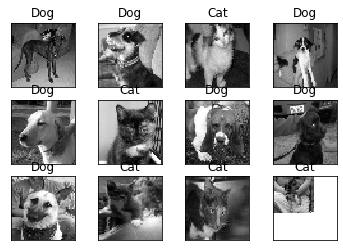

In [21]:
import matplotlib.pyplot as plt

# Se precisar criar o conjunto de dados
test_data = process_test_data()
# Se já possui o conjunto de dados salvo use esse comando:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

**Uma boa forma de ter ver acurácia é usar o Kaggle:** <https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data>

Estamos acertando cerca de 65%, o nosso modelo ainda precisa ser melhorado.

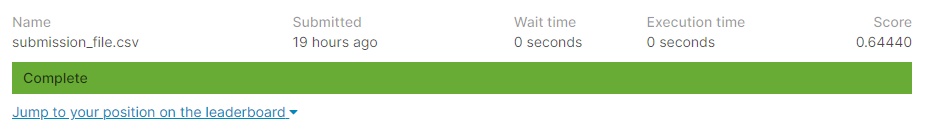

In [19]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:38<00:00, 327.50it/s]
